In [1]:
import os

import numpy as np
import pandas as pd
#import polars as pl
import matplotlib.pyplot as plt

import astropy

import scipy


from preprocess_light_curve import * 
 
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import lightning as L

from tqdm.auto import tqdm

import lcdata

In [2]:
object_table = pd.read_pickle('~/Supernovae_DeepLearning/object_ZTF_ALeRCE_19052024.pkl')
object_table

,oid,source_id,firstmjd,Av_MW,true_label
0,ZTF24aanbjel,2024iqx,60440.299120,0.0287,SN
1,ZTF24aamkufg,2024igh,60437.289560,0.0261,SNIa
2,ZTF24aajnwwr,2024hqr,60429.209850,0.0509,SNIa
3,ZTF18aaeopbs,2024glo,60407.202211,0.1403,SNIa
4,ZTF24aamtsgz,2024ipf,60438.397951,0.2484,SNIa
...,...,...,...,...,...
10868,ZTF19aamqjsh,2016cda,58558.284549,0.0447,SNIa
10869,ZTF18aarefgc,2016bey,60315.469572,0.0355,SNIa
10870,ZTF18aajleyh,2016ayf,58276.285139,0.0533,SNIa
10871,ZTF22abntkbk,2016nx,59870.374664,0.5834,SNIa


In [3]:
lightcurves_alercextns = pd.read_pickle('~/Supernovae_DeepLearning/data/lightcurves/lcs_transients_20240517.pkl')
lightcurves_alercextns.columns

Index(['oid', 'candid', 'rfid', 'mjd', 'fid', 'magpsf', 'sigmapsf'], dtype='object')

In [13]:
lightcurves = crossmatch_object_alerce(lightcurves_alercextns, object_table)
lightcurves.oid.unique().size

8042

In [5]:
def process_light_curve_parsnip(ligth_curve):

    new_light_curve = ligth_curve.copy()

    SIDEREAL_SCALE = 86400. / 86164.0905

    time = ligth_curve['mjd'].to_numpy()
    sidereal_time = time * SIDEREAL_SCALE

    # Initial guess of the phase. Round everything to 0.1 days, and find the decimal
    # that has the largest count.
    mode, count = scipy.stats.mode(np.round(sidereal_time % 1 + 0.05, 1), keepdims=True)
    guess_offset = mode[0] - 0.05

    # Shift everything by the guessed offset
    guess_shift_time = sidereal_time - guess_offset

    # Do a proper estimate of the offset.
    sidereal_offset = guess_offset + np.median((guess_shift_time + 0.5) % 1) - 0.5

    # Shift everything by the final offset estimate.
    shift_time = sidereal_time - sidereal_offset

    # Selecting the 
    s2n = ligth_curve['magpsf'] / ligth_curve['sigmapsf']
    s2n_mask = np.argsort(s2n)[-5:]

    cut_times = shift_time[s2n_mask]

    max_time = np.round(np.median(cut_times))

    # Convert back to a reference time in the original units. This reference time
    # corresponds to the reference of the grid in sidereal time.
    reference_time = ((max_time + sidereal_offset) / SIDEREAL_SCALE)
    grid_times = (time - reference_time) * SIDEREAL_SCALE
    time_indices = np.round(grid_times).astype(int) + 300 // 2 # 300 days
    time_mask = (
        (time_indices >= -100)
        & (time_indices < 300 + 100)
    )
    new_light_curve['grid_time'] = grid_times
    new_light_curve['time_index'] = time_indices
    new_light_curve = new_light_curve[time_mask]

    return new_light_curve

In [6]:
def plot_light_curve(light_curve):

    time = light_curve['mjd'].to_numpy()
    mag  = light_curve['magpsf'].to_numpy()

    fig, ax = plt.subplots()
    ax.plot(time,mag,'o')
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    ax.set_ylim(ax.get_ylim()[::-1])

In [47]:
one_light_curve = lightcurves[lightcurves['oid'] == lightcurves['oid'].unique()[15]]
one_light_curve = one_light_curve[one_light_curve.fid == 2]
one_light_curve

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label
2286,ZTF21aahfjrr,1516512163615015001,795120236.0,59270.512164,2,19.039776,0.134269,2021bwf,59248.491794,0.0243,SNIIn
2287,ZTF21aahfjrr,1518476713615015003,795120236.0,59272.476713,2,18.969805,0.127541,2021bwf,59248.491794,0.0243,SNIIn
2290,ZTF21aahfjrr,1524498953615015002,795120236.0,59278.498958,2,18.808460,0.078999,2021bwf,59248.491794,0.0243,SNIIn
2292,ZTF21aahfjrr,1528512033615015004,795120236.0,59282.512037,2,18.845530,0.074287,2021bwf,59248.491794,0.0243,SNIIn
2294,ZTF21aahfjrr,1538473143615015007,795120236.0,59292.473148,2,18.905285,0.094767,2021bwf,59248.491794,0.0243,SNIIn
2295,ZTF21aahfjrr,1541489723615015008,795120236.0,59295.489722,2,18.907856,0.084392,2021bwf,59248.491794,0.0243,SNIIn
2298,ZTF21aahfjrr,1543394723615015002,795120236.0,59297.394722,2,18.933313,0.105847,2021bwf,59248.491794,0.0243,SNIIn
2299,ZTF21aahfjrr,1546454143615015003,795120236.0,59300.454143,2,18.965603,0.160853,2021bwf,59248.491794,0.0243,SNIIn
2301,ZTF21aahfjrr,1550475973615015002,795120236.0,59304.475972,2,18.943283,0.161997,2021bwf,59248.491794,0.0243,SNIIn
2303,ZTF21aahfjrr,1548451873615015004,NaN,59302.451875,2,18.881300,0.113414,2021bwf,59248.491794,0.0243,SNIIn


In [48]:
one_light_curve.shape

(49, 11)

In [49]:
one_light_curve.mjd.max() - one_light_curve.mjd.min() 

130.8203586996533

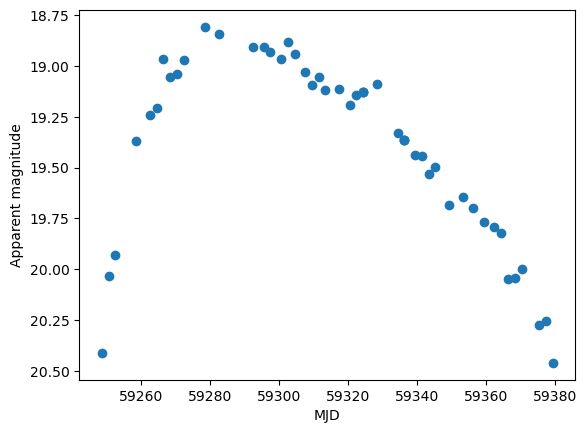

In [50]:
plot_light_curve(one_light_curve)

In [51]:
new_lc = process_light_curve_parsnip(one_light_curve)
new_lc

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label,grid_time,time_index
2286,ZTF21aahfjrr,1516512163615015001,795120236.0,59270.512164,2,19.039776,0.134269,2021bwf,59248.491794,0.0243,SNIIn,-25.026597,125
2287,ZTF21aahfjrr,1518476713615015003,795120236.0,59272.476713,2,18.969805,0.127541,2021bwf,59248.491794,0.0243,SNIIn,-23.056669,127
2290,ZTF21aahfjrr,1524498953615015002,795120236.0,59278.498958,2,18.808460,0.078999,2021bwf,59248.491794,0.0243,SNIIn,-17.017936,133
2292,ZTF21aahfjrr,1528512033615015004,795120236.0,59282.512037,2,18.845530,0.074287,2021bwf,59248.491794,0.0243,SNIIn,-12.993869,137
2294,ZTF21aahfjrr,1538473143615015007,795120236.0,59292.473148,2,18.905285,0.094767,2021bwf,59248.491794,0.0243,SNIIn,-3.005486,147
2295,ZTF21aahfjrr,1541489723615015008,795120236.0,59295.489722,2,18.907856,0.084392,2021bwf,59248.491794,0.0243,SNIIn,0.019348,150
2298,ZTF21aahfjrr,1543394723615015002,795120236.0,59297.394722,2,18.933313,0.105847,2021bwf,59248.491794,0.0243,SNIIn,1.929563,152
2299,ZTF21aahfjrr,1546454143615015003,795120236.0,59300.454143,2,18.965603,0.160853,2021bwf,59248.491794,0.0243,SNIIn,4.997361,155
2301,ZTF21aahfjrr,1550475973615015002,795120236.0,59304.475972,2,18.943283,0.161997,2021bwf,59248.491794,0.0243,SNIIn,9.030201,159
2303,ZTF21aahfjrr,1548451873615015004,NaN,59302.451875,2,18.881300,0.113414,2021bwf,59248.491794,0.0243,SNIIn,7.000562,157


In [52]:
new_lc.shape

(49, 13)

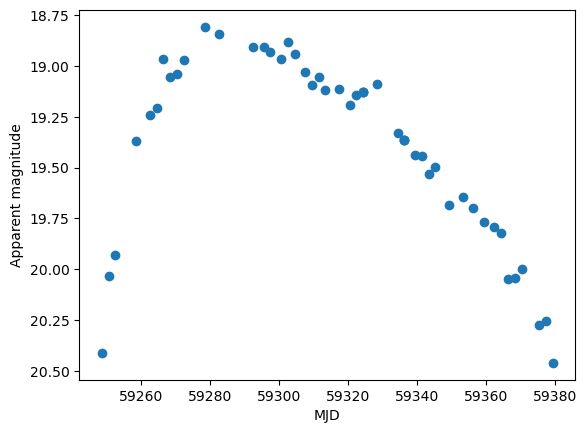

In [53]:
plot_light_curve(new_lc)

In [73]:
# self.settings['bands'] = 2
# self.settings['time_windows] = 300

def create_grid(lightcurve: pd.DataFrame):

    # Build a grid for the input
    grid_flux = np.zeros((1,
                            300))
    grid_weights = np.zeros_like(grid_flux)

    mask = (lightcurve['time_index'] >= 0) & (lightcurve['time_index'] < 300)
    lightcurve = lightcurve[mask]
   
   # Fill in the input array.
    grid_flux[0, lightcurve['time_index']] = lightcurve['magpsf']

    return grid_flux

In [76]:
grid = create_grid(new_lc)
grid.shape

(1, 300)

(21.484150800000002, -1.0230548000000002)

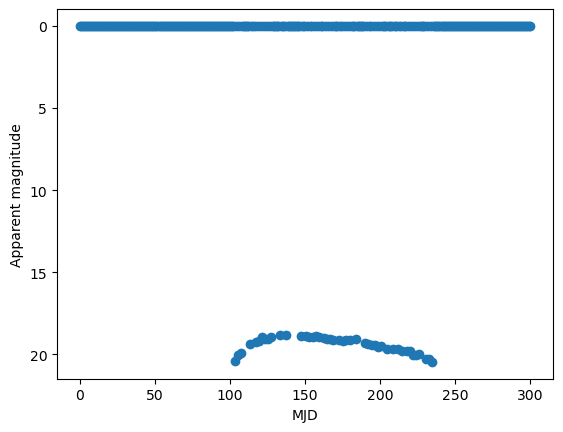

In [79]:
fig, ax = plt.subplots()
ax.scatter(x=np.linspace(0,300,300),y=grid[0,:])
ax.set_xlabel('MJD')
ax.set_ylabel('Apparent magnitude')
ax.set_ylim(ax.get_ylim()[::-1])